<a href="https://colab.research.google.com/github/simplysumanth/Kaggle_Competitions/blob/main/Cassava_Leaf_disease_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outline of the Classification Process
- Get data from kaggle
- Preprocess the data
- Create CustomDataset
- Write the training & Valid Loop
- Inference



### Get Data from Kaggle

In [1]:
#Upload the Kaggle API key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"simplysumanth","key":"4c4d5aafd1e3c9c5586c80c0cbb778a3"}'}

In [2]:
#Configure the Kaggle 
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# download the dataset
#!pip install kaggle
!kaggle competitions download -c cassava-disease

 99% 508M/515M [00:08<00:00, 67.2MB/s]
100% 515M/515M [00:09<00:00, 59.9MB/s]
  0% 0.00/645k [00:00<?, ?B/s]
100% 645k/645k [00:00<00:00, 41.9MB/s]
  0% 0.00/83.8k [00:00<?, ?B/s]
100% 83.8k/83.8k [00:00<00:00, 66.9MB/s]
 99% 1.04G/1.04G [00:18<00:00, 71.7MB/s]
100% 1.04G/1.04G [00:18<00:00, 60.8MB/s]
 98% 764M/777M [00:11<00:00, 77.4MB/s]
100% 777M/777M [00:11<00:00, 73.3MB/s]


So, we have now downloaded the dataset form kaggle, it has:
- train.zip -> contains 5 sub-folders, each of a class 
- test.zip -> the test data, on which the public scoreboard is scored.
- sample_submission.csv -> Sample format of how the output should be.
- extraimages.zip -> These are additional images, can be used for training.

### Preprocess the data

In [4]:
import os
import glob

In [5]:
!unzip "train.zip" -d "/content"
!unzip "test.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/cbsd/train-cbsd-685.jpg  
  inflating: /content/train/cbsd/train-cbsd-74.jpg  
  inflating: /content/train/cbsd/train-cbsd-875.jpg  
  inflating: /content/train/cbsd/train-cbsd-861.jpg  
  inflating: /content/train/cbsd/train-cbsd-60.jpg  
  inflating: /content/train/cbsd/train-cbsd-1165.jpg  
  inflating: /content/train/cbsd/train-cbsd-134.jpg  
  inflating: /content/train/cbsd/train-cbsd-652.jpg  
  inflating: /content/train/cbsd/train-cbsd-646.jpg  
  inflating: /content/train/cbsd/train-cbsd-120.jpg  
  inflating: /content/train/cbsd/train-cbsd-1171.jpg  
  inflating: /content/train/cbsd/train-cbsd-108.jpg  
  inflating: /content/train/cbsd/train-cbsd-1159.jpg  
  inflating: /content/train/cbsd/train-cbsd-1158.jpg  
  inflating: /content/train/cbsd/train-cbsd-109.jpg  
  inflating: /content/train/cbsd/train-cbsd-647.jpg  
  inflating: /content/train/cbsd/train-cbsd-1170.jpg  
  inflating: /content/train/

In [6]:
TRAIN_PATH = "/content/train"
TEST_PATH = "/content/test/0"

In [7]:
# Let's see how many samples are there for each class
for clas in os.listdir(TRAIN_PATH):
  print(f"The number of images in class {clas}: {len(os.listdir(TRAIN_PATH+'/'+clas))}")

The number of images in class cmd: 2658
The number of images in class cbb: 466
The number of images in class healthy: 316
The number of images in class cbsd: 1443
The number of images in class cgm: 773


Looks like there is imbalance in dataset, there are varying number of samples for each class. This might lead to a bias, where the class with more images might be most likely identified.

In [8]:
#lets create a list of the image path for train and test.
train_data, test_data = [],[]
for c in os.listdir(TRAIN_PATH):
  train_data.extend(glob.glob(os.path.join(TRAIN_PATH+"/"+c,'*.jpg')))
test_data = glob.glob(os.path.join(TEST_PATH, '*.jpg'))

In [9]:
len(train_data), len(test_data)

(5656, 3774)

In [10]:
train_data[0], test_data[0]

('/content/train/cmd/train-cmd-582.jpg', '/content/test/0/test-img-2779.jpg')

Now we have the train and test data, let's go ahead and create a custom dataset.

## Create Custom Dataset

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
class CustomDataset:
  def __init__(self,image_paths,augmentation=None):
    self.image_paths = image_paths
    self.augmentation = augmentation
  
  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    class_list = ['cbsd', 'cgm', 'cmd', 'healthy', 'cbb']
    target = self.image_paths[idx].split('-')[-2]
    if target in class_list:
      target = class_list.index(target)
    else:
      target = self.image_paths[idx].split('/')[-1] 
    image = Image.open(self.image_paths[idx])
    image = self.augmentation(image)

    return (image,target)

In [13]:
train_aug = transforms.Compose(
    [
     transforms.Resize((224,224)),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor()
    ]
)

In [14]:
train_dataset = CustomDataset(train_data,train_aug)

In [15]:
print(len(train_dataset))
train_dataset, valid_dataset = train_test_split(train_dataset, test_size= 0.2)
len(train_dataset) , len(valid_dataset)

5656


(4524, 1132)

In [16]:
train_data_loader = DataLoader(train_dataset, batch_size= 64, shuffle= True)
valid_data_loader = DataLoader(valid_dataset, batch_size= 64, shuffle= True)

In [17]:
train_data_loader, valid_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f2724e98b90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2724e98e90>)

In [18]:
for batch_idx, data in enumerate(train_data_loader):
  if batch_idx == 5:
    break
  else:
    data,target = data
    print(data.shape)
    print(target.shape)
    break
    # print(data["image"].shape)
    # print(data["target"].shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


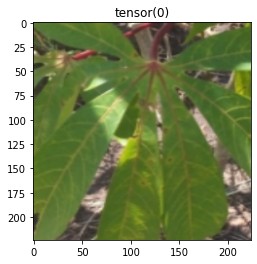

In [19]:
for batch_idx, data in enumerate(train_data_loader):
  data, target = data
  img = np.transpose(data[0].numpy(), (1,2,0))
  plt.imshow(img)
  plt.title(target[0])
  break

## Train/Valid Loop

In [20]:
##Define a model
model = models.resnet34(pretrained=True)
for params in model.parameters():
  params.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Linear(32,5)
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [23]:
epochs = 10
for epoch in range(epochs):
  epoch_loss, epoch_accuracy = 0,0

  for data,label in train_data_loader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    loss = criterian(output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = (output.argmax(dim=1) == label).float().mean()
    epoch_accuracy += accuracy/len(train_data_loader)
    epoch_loss += loss/len(train_data_loader)
  print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))

  with torch.no_grad():
    epoch_val_accuracy, epoch_val_loss = 0,0 

    for data,label in valid_data_loader:
      data = data.to(device)
      label = label.to(device)

      val_output = model(data)
      val_loss = criterian(val_output, label)

      val_accuracy = (val_output.argmax(dim=1) == label).float().mean()
      epoch_val_accuracy += val_accuracy/len(valid_data_loader)
      epoch_val_loss += val_loss/len(valid_data_loader)
  print('Epoch : {}, Val accuracy : {}, Val loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch : 1, train accuracy : 0.5719029903411865, train loss : 1.123320460319519
Epoch : 1, Val accuracy : 0.6520675420761108, Val loss : 0.9789403676986694
Epoch : 2, train accuracy : 0.6674935817718506, train loss : 0.8811265230178833
Epoch : 2, Val accuracy : 0.6919981241226196, Val loss : 0.8169722557067871
Epoch : 3, train accuracy : 0.6953625679016113, train loss : 0.8134585618972778
Epoch : 3, Val accuracy : 0.7080966234207153, Val loss : 0.7874915599822998
Epoch : 4, train accuracy : 0.7047455310821533, train loss : 0.7876277565956116
Epoch : 4, Val accuracy : 0.7036774158477783, Val loss : 0.790238082408905
Epoch : 5, train accuracy : 0.7288532853126526, train loss : 0.742284893989563
Epoch : 5, Val accuracy : 0.7237215638160706, Val loss : 0.7358185052871704
Epoch : 6, train accuracy : 0.7404369711875916, train loss : 0.7145231366157532
Epoch : 6, Val accuracy : 0.7190657258033752, Val loss : 0.7409272193908691
Epoch : 7, train accuracy : 0.7275528311729431, train loss : 0.7150

In [24]:
##Preparing the test data loader
#TestDataSet
test_aug = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor()              
])


test_dataset = CustomDataset(test_data,test_aug)
test_data_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)

In [56]:
model.eval()
y_probs = []
labels = []
with torch.no_grad():
  for data,target in test_data_loader:
    #(batch[:-1]) -> gives out list of all the images
    #batch[-1] -> list of all labels corresponding to those images
    # batch = batch.to(device)
    # inputs, labels = batch[:-1], batch[-1]
    data = data.to(device)
    y_prob = model(data)
    y_prob_softmax = torch.nn.functional.softmax(y_prob, dim=1)
    #print(y_prob_softmax)
    y_probs.extend(int(torch.argmax(i).cpu().numpy()) for i in y_prob_softmax)
    labels.extend(target)


In [64]:
classes = ['cbsd', 'cgm', 'cmd', 'healthy', 'cbb']
final_list = list(map(lambda x: classes[x], y_probs))


In [65]:
import pandas as pd

In [66]:
dataframe = pd.DataFrame({"Category":final_list, "Id":labels})
dataframe.head()

,Category,Id
0,cbsd,test-img-2779.jpg
1,cmd,test-img-1509.jpg
2,cmd,test-img-1434.jpg
3,cmd,test-img-766.jpg
4,cmd,test-img-1123.jpg


In [68]:
dataframe.to_csv("first_submission_resnet_34.csv",index=False)